# CBC Waveform in wavelet domain

## Basic Waveform

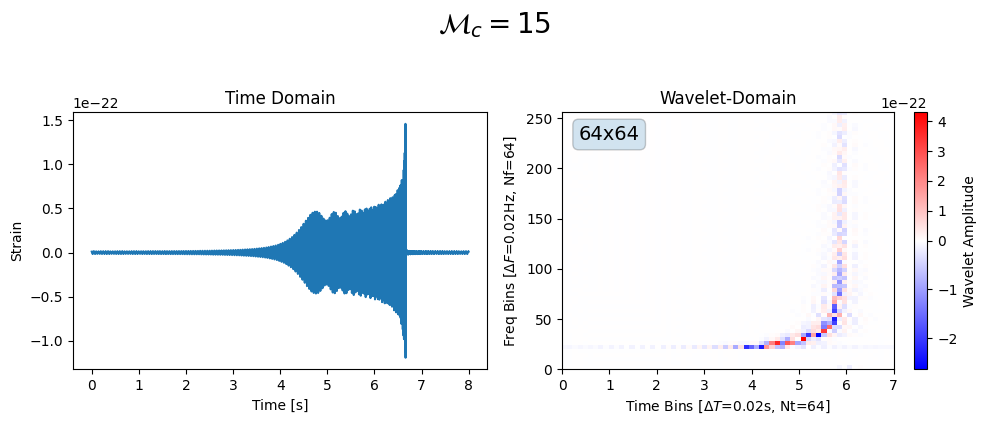

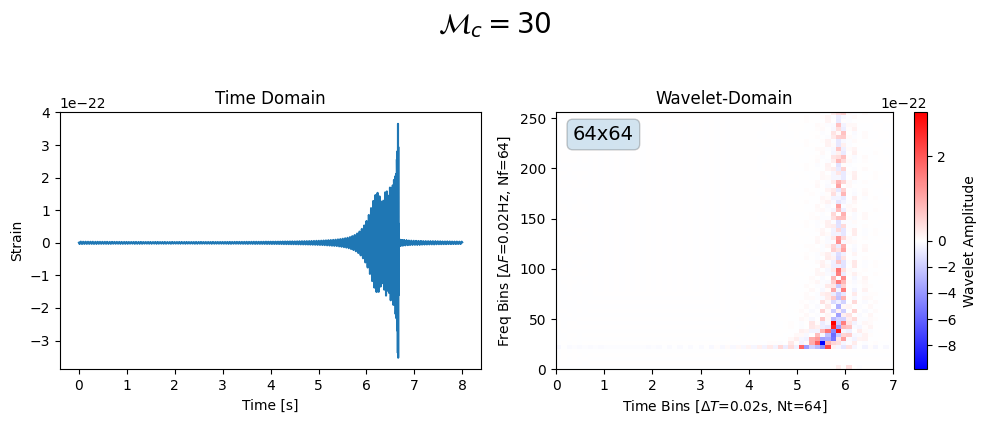

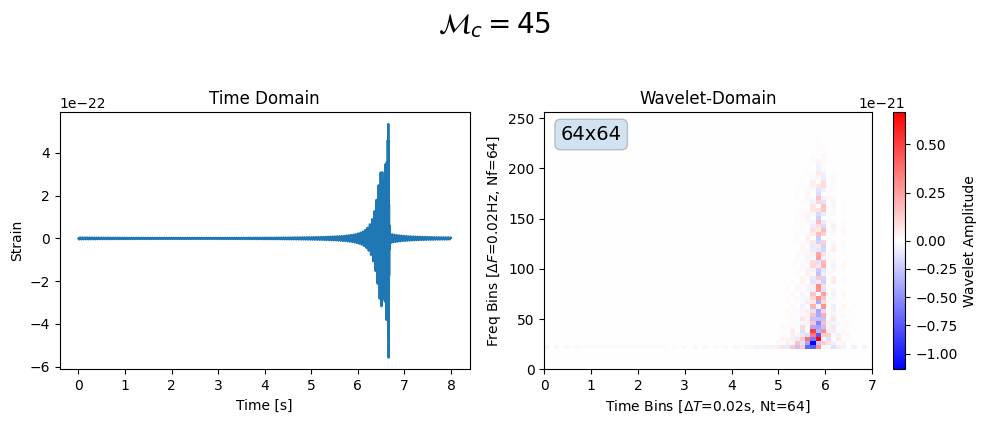

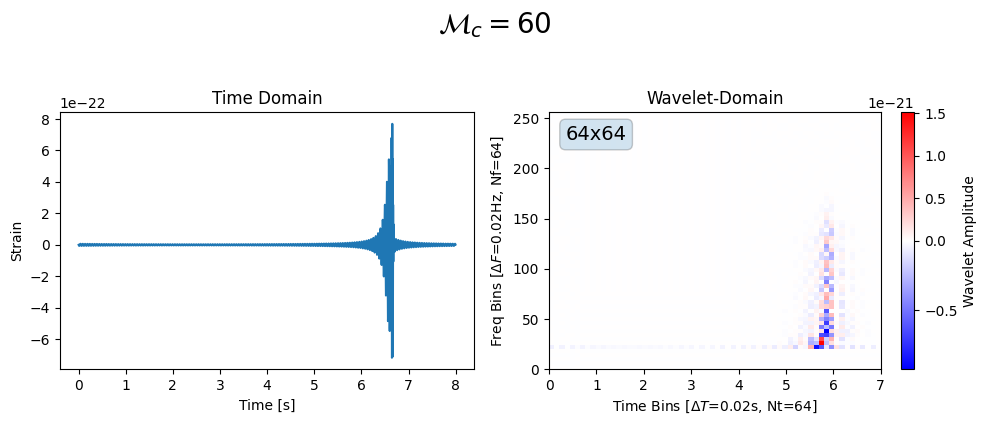

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from pycbc.conversions import mass1_from_mchirp_q, mass2_from_mchirp_q
from pywavelet.waveform_generator.generators import FunctionalWaveformGenerator
from pywavelet.plotting import plot_wavelet_domain_grid
from pywavelet.transforms.types import TimeSeries

import bilby
import numpy as np
import logging

bilby_logger = logging.getLogger("bilby")
bilby_logger.setLevel(logging.ERROR)

Nf, Nt = 64, 64
mult = 16

DURATION = 8
SAMPLING_FREQUENCY = 512
MINIMUM_FREQUENCY = 20

CBC_GENERATOR = bilby.gw.WaveformGenerator(
    duration=DURATION,
    sampling_frequency=SAMPLING_FREQUENCY,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(
        waveform_approximant="IMRPhenomD",
        reference_frequency=20.0,
        minimum_frequency=MINIMUM_FREQUENCY,
    ),
)

GW_PARMS = dict(
    mass_1=30,
    mass_2=30,  # 2 mass parameters
    a_1=0.1,
    a_2=0.1,
    tilt_1=0.0,
    tilt_2=0.0,
    phi_12=0.0,
    phi_jl=0.0,  # 6 spin parameters
    ra=1.375,
    dec=-1.2108,
    luminosity_distance=2000.0,
    theta_jn=0.0,  # 7 extrinsic parameters
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
)


def cbc_waveform(mc, q=1):
    m1, m2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(
        mc, q
    )

    params = GW_PARMS.copy()
    params["mass_1"] = m1
    params["mass_2"] = m2

    h = CBC_GENERATOR.time_domain_strain(params)["plus"]
    # template sets max amplitude t=end of waveform, so we roll it back a bit
    h = np.roll(h, -len(h) // 6)
    t = CBC_GENERATOR.time_array
    return TimeSeries(h, t)


def create_cbc_wavelet_waveform_generator():
    hfunc = lambda mc: cbc_waveform(mc, q=1)
    # NOTE: Nf * Nt == len(h) returned from h-func
    waveform_generator = FunctionalWaveformGenerator(hfunc, Nt=Nt, mult=mult)
    return waveform_generator


wavelet_generator = create_cbc_wavelet_waveform_generator()
for i, mc in enumerate([15, 30, 45, 60]):
    wavelet = wavelet_generator(mc=mc)
    ht = cbc_waveform(mc=mc, q=1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(ht.time, ht.data)
    axes[0].set_xlabel("Time [s]")
    axes[0].set_ylabel("Strain")
    axes[0].set_title(f"Time Domain")
    fig = wavelet.plot(ax=axes[1])
    axes[1].set_title(f"Wavelet-Domain")
    fig.suptitle(r"$\mathcal{M}_c=" + f"{mc}$", fontsize=20, y=1.05)
    fig.tight_layout()
    fig.savefig(f"cbc_wavelet_mc_{mc}.png")
    fig.show()

## Waveforms in noise

Let's inject the signals into LIGO detector noise (at design sensitivity), compute the SNR in the time and the wavelet domains.

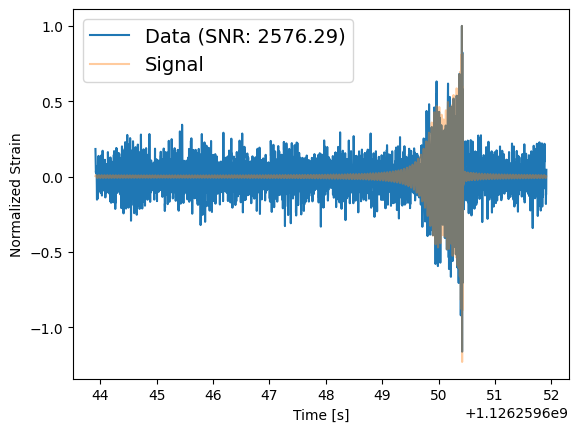

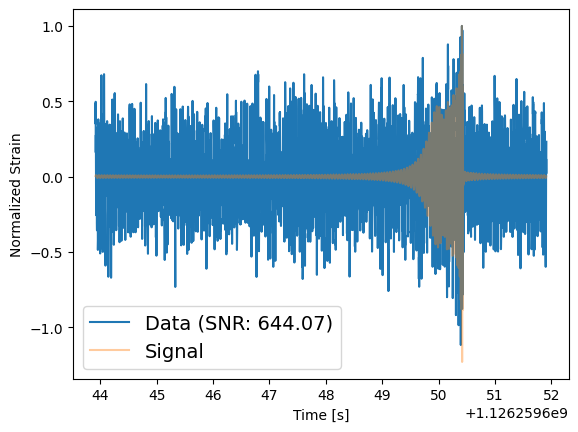

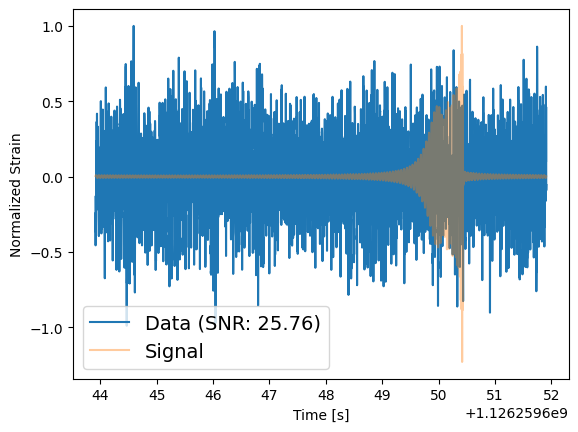

In [2]:
def get_ifo(t0):
    ifos = bilby.gw.detector.InterferometerList(["H1"])  # design sensitivity
    ifos.set_strain_data_from_power_spectral_densities(
        sampling_frequency=SAMPLING_FREQUENCY,
        duration=DURATION,
        start_time=t0,
    )
    return ifos


def inject_signal_in_noise(mc, q=1, distance=1000):
    injection_parameters = GW_PARMS.copy()
    (
        injection_parameters["mass_1"],
        injection_parameters["mass_2"],
    ) = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(
        mc, q
    )
    injection_parameters["luminosity_distance"] = distance

    ifos = get_ifo(injection_parameters["geocent_time"] + 1.5)
    ifos.inject_signal(
        waveform_generator=CBC_GENERATOR, parameters=injection_parameters
    )
    ifo: bilby.gw.detector.Interferometer = ifos[0]

    waveform = CBC_GENERATOR.frequency_domain_strain(injection_parameters)
    signal = ifo.get_detector_response(waveform, injection_parameters)
    snr = ifo.optimal_snr_squared(signal)
    return ifo.time_array, ifo.strain_data.time_domain_strain, np.abs(snr)


for d in [500, 1000, 5000]:
    t, h, _ = inject_signal_in_noise(mc=30, q=1, distance=0.1)
    _, data, snr = inject_signal_in_noise(mc=30, q=1, distance=d)

    plt.plot(t, data / np.max(data), label=f"Data (SNR: {snr:.2f})")
    plt.plot(t, h / np.max(h), alpha=0.4, label=f"Signal")
    plt.legend(fontsize=14)
    plt.ylabel("Normalized Strain")
    plt.xlabel("Time [s]")
    plt.show()

## Wavelet domain PSD

We need a wavelet domain PSD... Lets generate this by taking the median of several wavelet transforms of just noise.

In [3]:
def __get_noise_wavelet_data(t0):
    noise = get_ifo(t0)[0].strain_data.time_domain_strain
    noise_wavelet = from_time_to_wavelet(noise, Nf, Nt)
    return noise_wavelet


def __get_wavelet_psd_from_median_noise(n=32):
    """n: number of noise wavelets to take median of"""
    noise_wavelets = []
    for i in range(n):
        np.random.seed(i)
        noise_wavelets.append(__get_noise_wavelet_data(i * DURATION))
    return np.median(np.array(noise_wavelets), axis=0)


psd_wavelet = __get_wavelet_psd_from_median_noise()
fig = plot_wavelet_domain_grid(psd_wavelet, Nf, Nt)

NameError: name 'from_time_to_wavelet' is not defined

## Wavelet domain SNR

In [70]:
from pywavelet.transforms import from_time_to_wavelet
from pywavelet.utils.snr import compute_snr

t, h, _ = inject_signal_in_noise(mc=30, q=1, distance=0.1)
_, data, time_domain_snr = inject_signal_in_noise(mc=30, q=1, distance=5000)
data_wavelet = from_time_to_wavelet(data, Nf, Nt)
h_wavelet = from_time_to_wavelet(h, Nf, Nt)

wavelet_snr = compute_snr(h_wavelet, data_wavelet, psd_wavelet)
print(wavelet_snrpsd_f)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
